<a href="https://colab.research.google.com/github/LighterBund/OIBSIP/blob/Email-Spam-Detection/Email_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score


In [12]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [13]:
data.shape

(5572, 5)

In [14]:
data.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [15]:
data = data.dropna(how='any', axis=1)
data.columns = ['target', 'message']
data.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<Axes: xlabel='target', ylabel='count'>

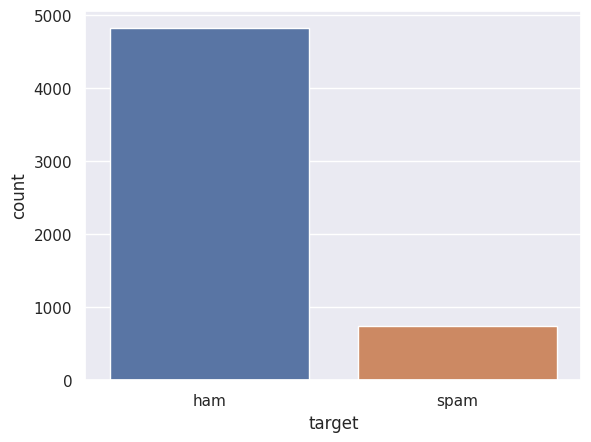

In [16]:
sns.countplot(x=data.target)

In [17]:
data['word_length'] = data['message'].apply(lambda x: len(x.split(' ')))
data['char_length'] = data['message'].apply(len)

(0.0, 75.0)

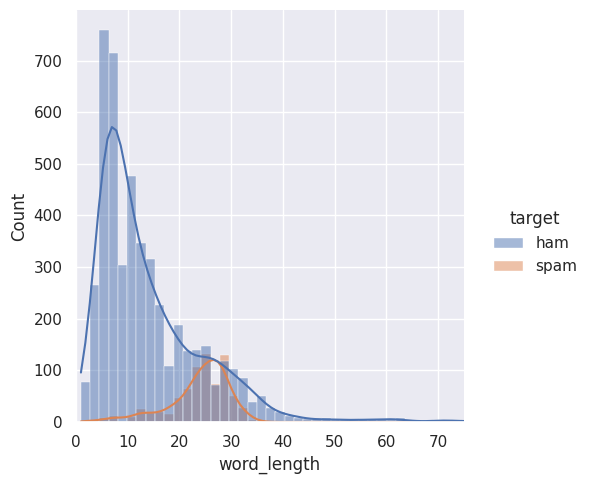

In [18]:
sns.displot(data, x='word_length', hue='target', kde=True)
plt.xlim(0,75)

(0.0, 300.0)

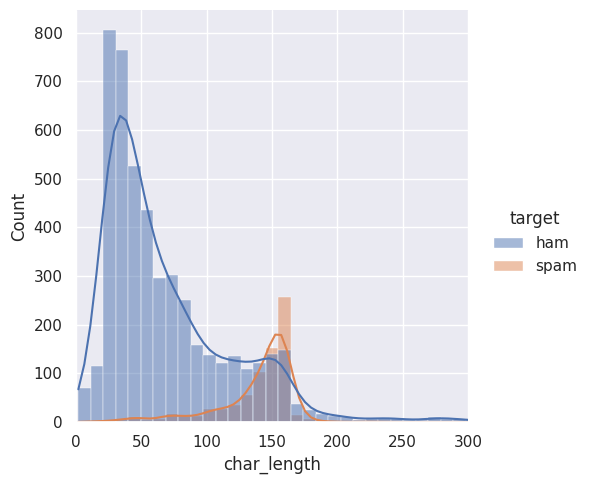

In [19]:
sns.displot(data, x='char_length', hue='target', kde=True)
plt.xlim(0,300)

In [23]:
from nltk.corpus import stopwords
import string # builtin string module

stopword_list = stopwords.words('english')

def clean(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = [word for word in text.split() if word not in stopword_list]
    text = ' '.join(text)
    return text

data.message = data.message.apply(clean)

In [24]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(data.target)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

tfidf = TfidfVectorizer()
features = tfidf.fit_transform(data.message)

In [26]:
from sklearn.model_selection import GridSearchCV
import copy

scoring = ['f1', 'accuracy', 'recall', 'precision']
gs = GridSearchCV(MultinomialNB(), param_grid={'alpha': np.linspace(0.05, 1, num=20)}, scoring=scoring, refit='f1')
X = copy.deepcopy(features)
y = copy.deepcopy(target)

gs.fit(X, y)
results = gs.cv_results_

In [28]:
def plot_crossval_results(crossval_results, param_key):
    X_axis = np.array(crossval_results[param_key].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['r', "k", 'b', "g"]):
        sample_score_mean = crossval_results["mean_test_%s" % (scorer)]
        sample_score_std = crossval_results["std_test_%s" % (scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            '-',
            color=color,
            alpha=1,
            label="%s" % (scorer),
        )

        best_index = np.nonzero(crossval_results["rank_test_%s" % scorer] == 1)[0][0]
        best_score = crossval_results["mean_test_%s" % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot(
            [
                X_axis[best_index],
            ]
            * 2,
            [0, best_score],
            linestyle="-.",
            color=color,
            marker="x",
            markeredgewidth=3,
            ms=8,
        )

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

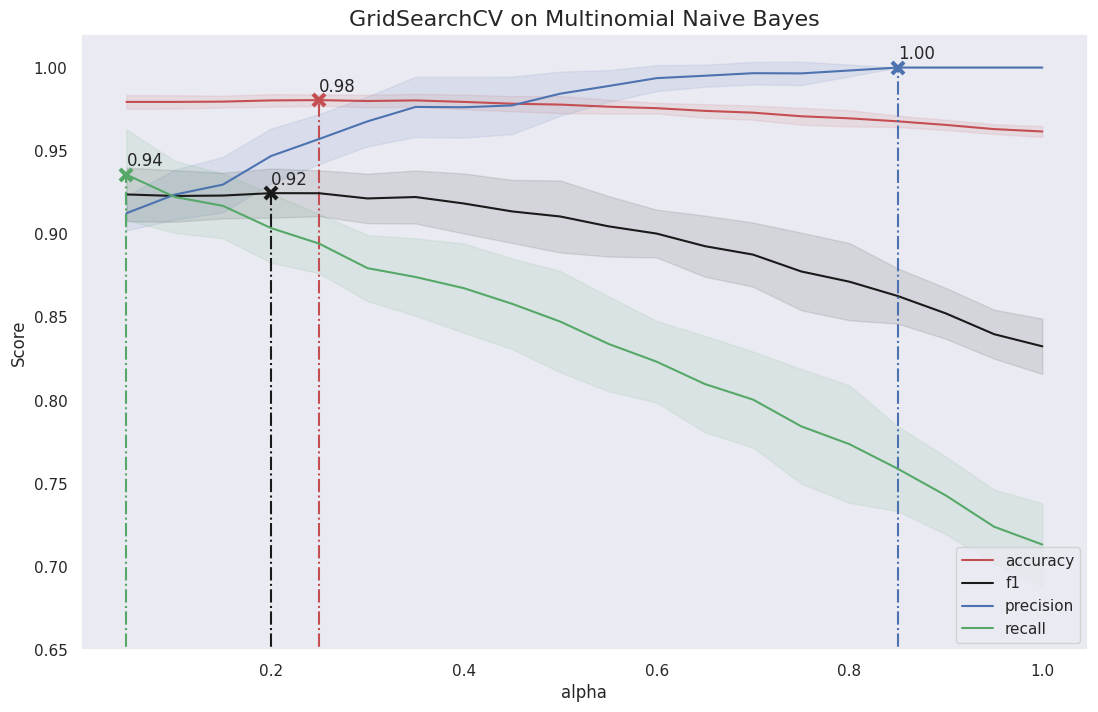

In [29]:
plt.figure(figsize=(13, 8))
plt.title("GridSearchCV on Multinomial Naive Bayes", fontsize=16)

plt.xlabel("alpha")
plt.ylabel("Score")

ax = plt.gca()
ax.set_ylim(0.65, 1.02)

plot_crossval_results(results, 'param_alpha')

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

mnb = MultinomialNB(alpha=0.2)
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2)
mnb.fit(x_train, y_train)
y_pred = mnb.predict(x_test)

{'f1': 0.9285714285714285, 'accuracy': 0.9802690582959641}

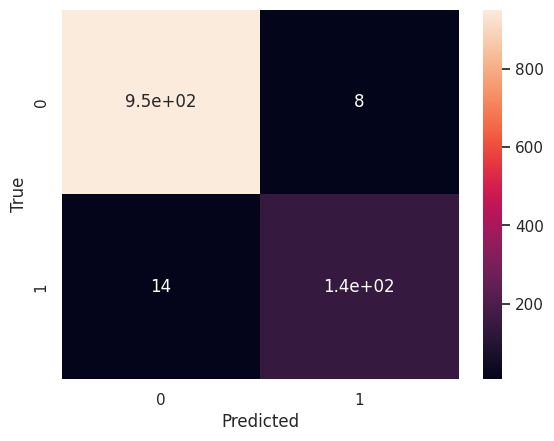

In [35]:
conf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_matrix, annot=True)
ax.set(xlabel="Predicted", ylabel="True")
scores = {'f1': f1_score(y_test, y_pred), 'accuracy': accuracy_score(y_test, y_pred)}
scores